# Photometric calibration

In this tutorial, the 2MASS photometry of PZ Tel A is fitted with a IRTF spectrum of a G8V type star. The plots show the posterior distribution scaling parameter that was fitted and randomly selected spectra from the posterior distribution with the best-fit synthetic photometry and the observed photometry (which are overlapping). The residuals are shown in terms of the uncertainty of the 2MASS photometry.

In [1]:
import species
import wget
from IPython.display import Image

In [2]:
species.SpeciesInit()

Initiating species v0.1.0... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


In [3]:
distance = (47.13, 0.13)  # [pc]

In [4]:
magnitudes = {'2MASS/2MASS.J':(6.856, 0.021),
              '2MASS/2MASS.H':(6.486, 0.049),
              '2MASS/2MASS.Ks':(6.366, 0.024)}

In [5]:
filters = list(magnitudes.keys())

In [6]:
wget.download('http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/G8V_HD75732.txt',
              out='data/G8V_HD75732.txt')

'data/G8V_HD75732.txt'

In [7]:
database = species.Database()

In [8]:
database.add_object(object_name='PZ Tel A',
                    distance=distance,
                    app_mag=magnitudes)

Adding filter: 2MASS/2MASS.J... [DONE]
Adding Vega spectrum... [DONE]
Adding filter: 2MASS/2MASS.H... [DONE]
Adding filter: 2MASS/2MASS.Ks... [DONE]
Adding object: PZ Tel A... [DONE]


In [9]:
database.add_calibration(filename='data/G8V_HD75732.txt',
                         tag='G8V_HD75732')

Adding calibration spectrum: G8V_HD75732... [DONE]


In [10]:
fit = species.FitSpectrum(object_name='PZ Tel A',
                          filters=None,
                          spectrum='G8V_HD75732',
                          bounds={'scaling':(0., 1e0)})

Getting object: PZ Tel A... [DONE]


In [11]:
fit.run_mcmc(nwalkers=200,
            nsteps=1000,
            guess={'scaling':5e-1},
            tag='pztel')

Running MCMC...


100%|██████████| 1000/1000 [00:06<00:00, 166.03it/s]


Mean acceptance fraction: 0.787
Integrated autocorrelation time = [3830.83832333]


In [12]:
species.plot_walkers(tag='pztel',
                     nsteps=None,
                     offset=(-0.2, -0.08),
                     output='walkers.png')

Plotting walkers: walkers.png... [DONE]


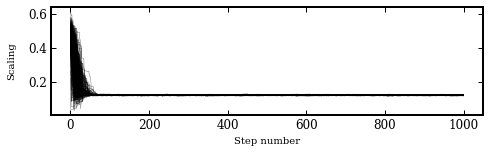

In [13]:
Image('walkers.png')

In [14]:
species.plot_posteriors(tag='pztel',
                        burnin=500,
                        offset=(-0.3, -0.10),
                        title_fmt='.4f',
                        output='posterior.png')

Plotting posteriors: posterior.png... [DONE]


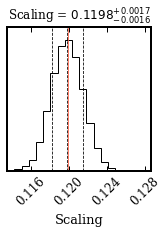

In [15]:
Image('posterior.png')

In [16]:
objectbox = database.get_object(object_name='PZ Tel A',
                                filters=None)

Getting object: PZ Tel A... [DONE]


In [17]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    burnin=500,
                                    random=30,
                                    wavel_range=(0.1, 50.0),
                                    spec_res=None)

Getting MCMC spectra: 100%|██████████| 30/30 [00:00<00:00, 1190.47it/s]


In [18]:
median = database.get_median_sample(tag='pztel',
                                    burnin=500)

In [19]:
synphot = species.multi_photometry(datatype='calibration',
                                   spectrum='G8V_HD75732',
                                   filters=filters,
                                   parameters=median)

Calculating synthetic photometry... [DONE]


In [20]:
residuals = species.get_residuals(datatype='calibration',
                                  spectrum='G8V_HD75732',
                                  parameters=median,
                                  filters=filters,
                                  objectbox=objectbox,
                                  inc_phot=True,
                                  inc_spec=False)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]


In [21]:
readcalib = species.ReadCalibration(spectrum_tag='G8V_HD75732',
                                    filter_name=None)

In [22]:
spectrum = readcalib.get_spectrum(model_param=median)

In [23]:
species.plot_spectrum(boxes=(samples, spectrum, objectbox, synphot),
                      filters=filters,
                      colors=('gray', 'black', ('black', ), 'black', 'tomato', 'teal'),
                      residuals=residuals,
                      xlim=(1., 2.5),
                      ylim=(-1.5e-12, 1.1e-11),
                      scale=('linear', 'linear'),
                      offset=(-0.3, -0.08),
                      output='spectrum.png')

Plotting spectrum: spectrum.png... [DONE]


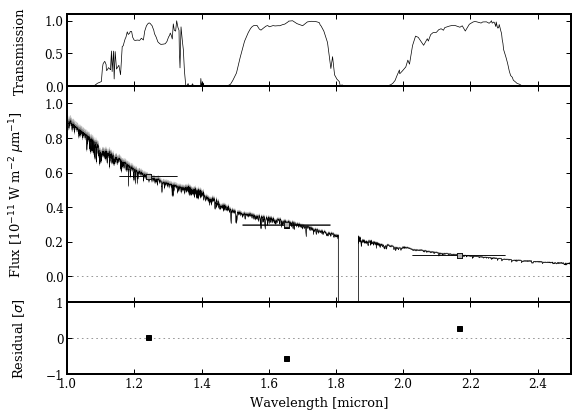

In [24]:
Image('spectrum.png')

In [25]:
readcalib = species.ReadCalibration(spectrum_tag='G8V_HD75732',
                                    filter_name='Paranal/SPHERE.IRDIS_D_H23_2')

flux = readcalib.get_flux(model_param=median)
app_mag, _ = readcalib.get_magnitude(model_param=median)

print(f'VLT/SPHERE H2 [W m-2 micron-1] = {flux:.2e}')
print(f'VLT/SPHERE H2 [mag] = {app_mag:.2f}')

Adding filter: Paranal/SPHERE.IRDIS_D_H23_2... [DONE]
VLT/SPHERE H2 [W m-2 micron-1] = 3.30e-12
VLT/SPHERE H2 [mag] = 6.50
